In [34]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
import os.path
import pandas as pd
import numpy as np
import matplotlib as mpl
import gc_colors
mpl.rcParams["figure.figsize"] = 15, 12
mpl.rcParams["lines.markeredgewidth"] = 1.0

# Function definitions

In [35]:
def get_medians(data, n_parts=4):
    """Helper function for median uniformity."""
    datablocks = np.split(data, n_parts)
    medians = []
    for block in datablocks:
        medians.append(np.median(block))
        
    return medians

def median_uniformity(data, n_parts=4):
    """Split data in n_parts, calc median for each split and return the ratio of the min(medians)/max(medians).
    A larger value translates to a better uniformity!"""
    medians = get_medians(data, n_parts)
    
    return min(medians)/max(medians)

# Load the necessary files and containing data

In [36]:
#Arduino files -----------------------------------------------------------------------------------------------------
arduino_files = glob.glob("Lightuniformity_Meas/LED5_INT50/HD*.csv")  #Bars on my desk
arduino_files_production = glob.glob("Lightuniformity_Meas/LED5_INT50/In_Production/HD*.csv")  #Bars in production
lightbar_dict = {}    #Dict containing the data (as pandas DataFrame) with lightbar name as key (e.g. "HD70")

for in_production, files in enumerate([arduino_files, arduino_files_production]):
    for filename in files:
        lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
        lightbar_nr = int(lightbar[2:])
        lightbar_dict[lightbar_nr] = { "Arduino_Data" : pd.read_csv(filename, delim_whitespace=True, 
                                                                          comment='#', names=["Ch", "Blue", "Red"]),
                                             "In_Production" : in_production }        

        
        
#Mattest files (optional) ------------------------------------------------------------------------------------------
mattest_files = glob.glob("Lightuniformity_Meas/Mattest/HD*.csv")  #Bars on my desk
mattest_files_production = glob.glob("Lightuniformity_Meas/Mattest/In_Production/HD*.csv")  #Bars in production

for in_production, files in enumerate([mattest_files, mattest_files_production]):
    for filename in files:
        lightbar = os.path.splitext(os.path.basename(filename))[0]    #Lightbar name (e.g "HD70")
        lightbar_nr = int(lightbar[2:-5])
        led_brightness = int(lightbar[-2:])
        
        if not lightbar_dict.has_key(lightbar_nr):
            raise ValueError("ERROR: Lightbar {} has mattest data but no arduino data!".format(lightbar_nr))
        lightbar_dict[lightbar_nr]["Mattest_Data"] = pd.read_csv(filename, sep=";",  skiprows=15,
                                                                 names=["Ch", "Pedestal", "Gain", "Mean_pixels"])
        lightbar_dict[lightbar_nr]["Mattest_Brightness"] = led_brightness
        
        if lightbar_dict[lightbar_nr]["In_Production"] != in_production:
            print("WARNING: Inconsistency of 'In_Production' value between arduino and mattest data for lightbar {}!"
                  .format(lightbar_nr))

#Convert to pandas DataFrame
df = pd.DataFrame(lightbar_dict).transpose()
df["Lightbar"] = df.index

#Read uniformity file
uniformity_df = pd.read_csv("Lightuniformity_Meas/Mattest/Uniformity.txt", names=["Lightbar", "Uniformity"], 
                            delim_whitespace=True, comment="#")
uniformity_df.index = np.asarray(uniformity_df["Lightbar"])
uniformity_df = uniformity_df.drop("Lightbar", 1)

df = pd.concat([df, uniformity_df], axis=1)
df.head()

,Arduino_Data,In_Production,Mattest_Brightness,Mattest_Data,Lightbar,Uniformity
48,Ch Blue Red 0 0 0.35168...,1,45,Ch Pedestal Gain Mean_pixels 0 ...,48,good
49,Ch Blue Red 0 0 0.35096...,1,44,Ch Pedestal Gain Mean_pixels 0 ...,49,good
50,Ch Blue Red 0 0 0.36175...,1,45,Ch Pedestal Gain Mean_pixels 0 ...,50,good
51,Ch Blue Red 0 0 0.32178...,1,44,Ch Pedestal Gain Mean_pixels 0 ...,51,good
52,Ch Blue Red 0 0 0.35556...,1,44,Ch Pedestal Gain Mean_pixels 0 ...,52,good


# Correct the strange step in the mattest data

In [37]:
n = 10 #Number of median values to take for calc. the steps
df["Mattest_Stepfactor"] = -10.
for i, row in df.iterrows():
    data = np.array(row["Mattest_Data"]["Mean_pixels"])
    idx = 256
    stepfactor_low = np.median(data[idx-n:idx])/np.median(data[idx:idx+10])
    idx = 384
    stepfactor_up = np.median(data[idx:idx+n])/np.median(data[idx-n:idx])
    stepfactor = (stepfactor_low+stepfactor_up)/2
    data[256:384] = data[256:384] * stepfactor
    row["Mattest_Data"]["Mean_pixels_corrected"] = data
    df.set_value(i, 'Mattest_Stepfactor', stepfactor)

# Add mean and rel. std to the dataframe

In [38]:
df["Arduino_Mean"] = -10.
df["Arduino_Rel_Std"] = -10.
df["Mattest_Mean"] = -10.
df["Mattest_Rel_Std"] = -10.

for i, row in df.iterrows():
    arduino_data = row["Arduino_Data"]["Red"]
    mattest_data = row["Mattest_Data"]["Mean_pixels_corrected"]
    
    arduino_mean = np.mean(arduino_data)
    arduino_std = np.std(arduino_data)
    
    mattest_mean = np.mean(mattest_data)
    mattest_std = np.std(mattest_data)
    
    df.set_value(i, "Arduino_Mean", arduino_mean)
    df.set_value(i, "Arduino_Rel_Std", arduino_std/arduino_mean)

    df.set_value(i, "Mattest_Mean", mattest_mean)
    df.set_value(i, "Mattest_Rel_Std", mattest_std/mattest_mean)

# Calculate a different variable for the light uniformity

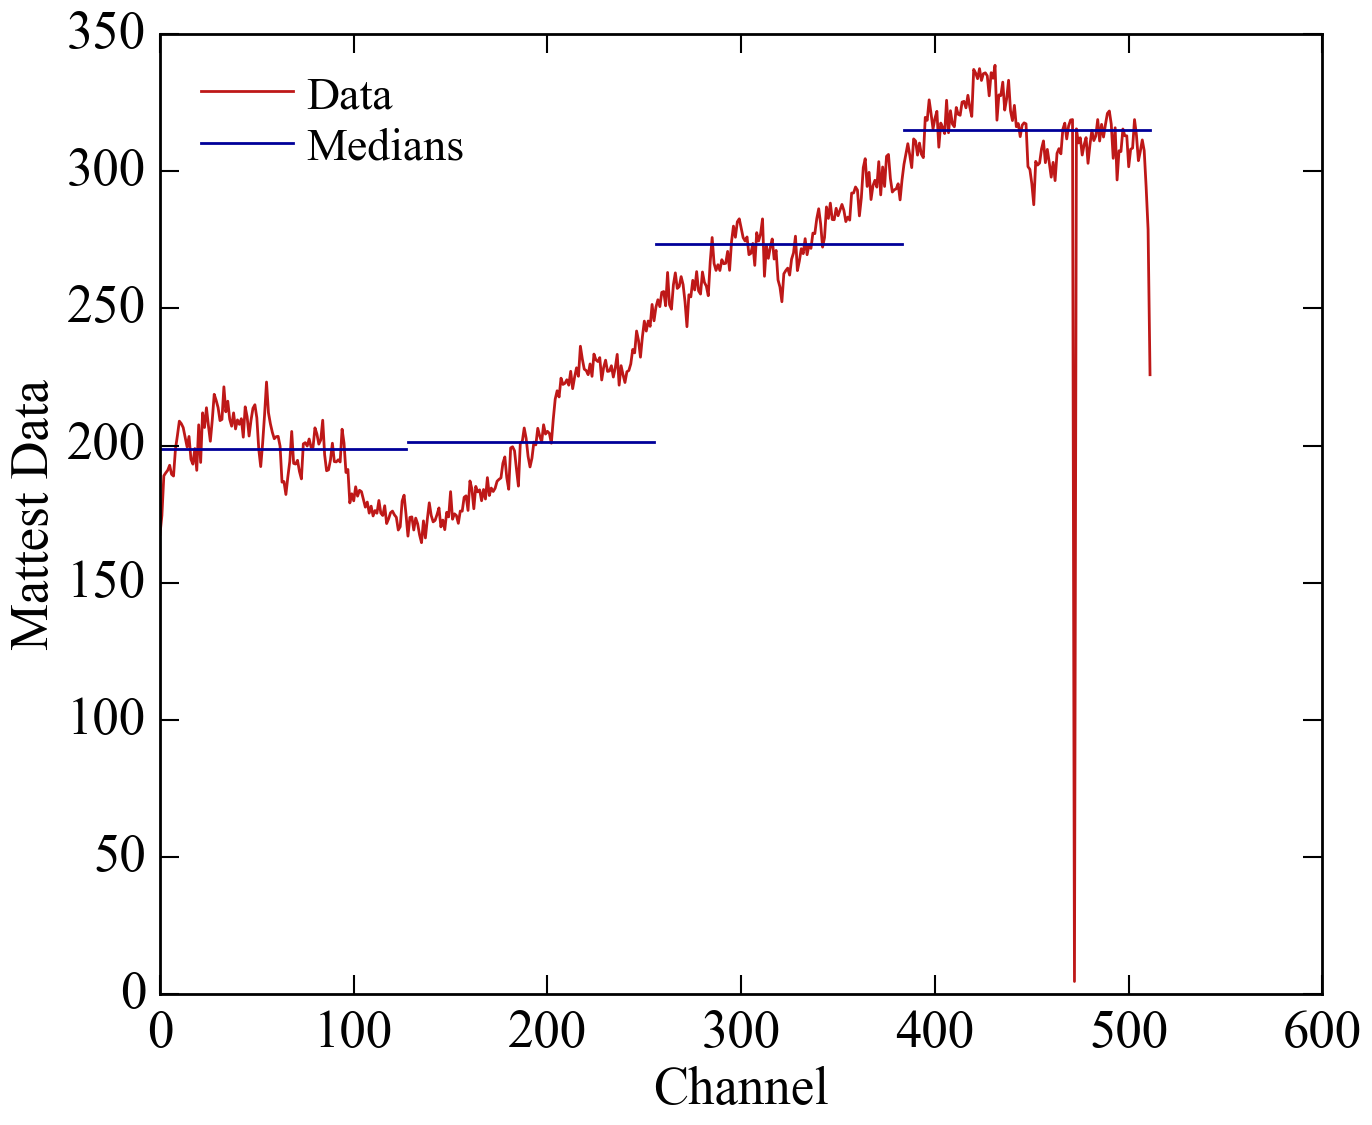

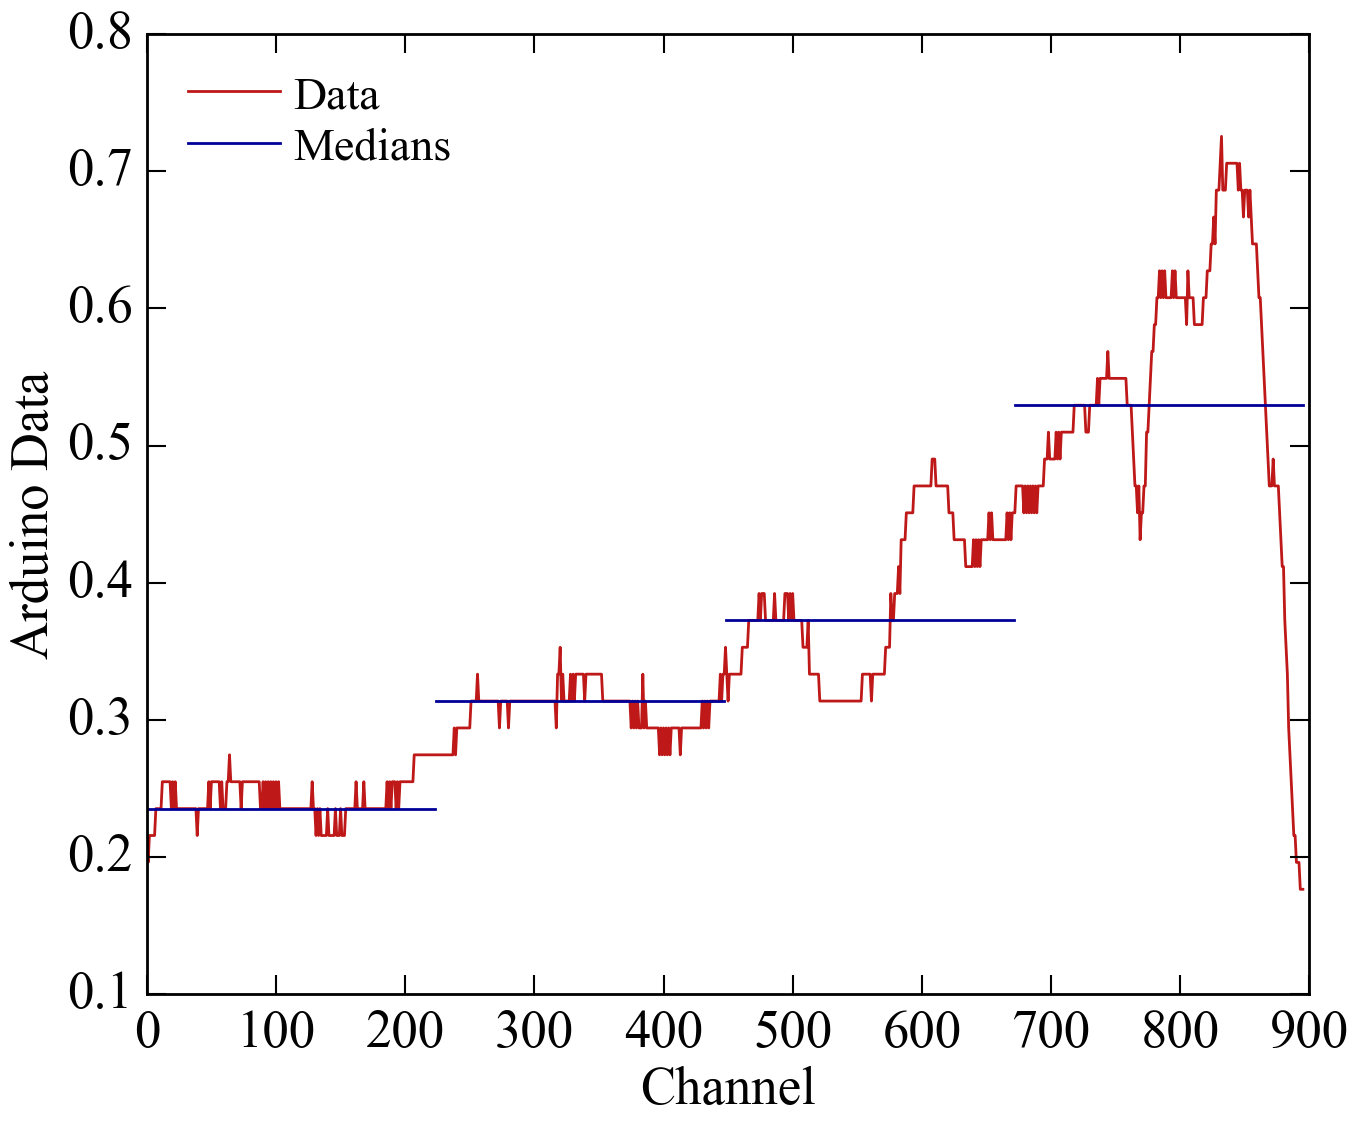

In [78]:
n_parts = 4

df["Mattest_Median_Uniformity"] = -10.
df["Arduino_Median_Uniformity"] = -10.
for i, row in df.iterrows():
    data_mattest = np.array(row["Mattest_Data"]["Mean_pixels_corrected"])
    data_arduino = np.array(row["Arduino_Data"]["Red"])
    
    mattest_uniformity = median_uniformity(data_mattest, n_parts)
    arduino_uniformity = median_uniformity(data_arduino, n_parts)

    df.set_value(i, "Mattest_Median_Uniformity", mattest_uniformity)
    df.set_value(i, "Arduino_Median_Uniformity", arduino_uniformity)
    

#Control plot
lightbar = 70
data_mattest = df.loc[lightbar]["Mattest_Data"]["Mean_pixels_corrected"]
data_arduino = df.loc[lightbar]["Arduino_Data"]["Red"]

for idx, data in enumerate([data_mattest, data_arduino]):
    medians = get_medians(data, n_parts)
    xticks = np.split(np.asarray(range(len(data))), n_parts)

    plt.plot(range(len(data)), data, "gcred", label="Data")
    for i in range(n_parts):
        if i == 0:
            plt.plot([xticks[i][0], xticks[i][-1]], [medians[i], medians[i]], "gcblue", label = "Medians")
        else:
            plt.plot([xticks[i][0], xticks[i][-1]], [medians[i], medians[i]], "gcblue")
    plt.xlabel("Channel")    
    if idx == 0:
        plt.ylabel("Mattest Data")
    elif idx == 1:
        plt.ylabel("Arduino Data")
    plt.legend(loc = "upper left")
    plt.show()
    plt.close()

# Plots

### Arduino mean vs. LED brightness of mattest measurement

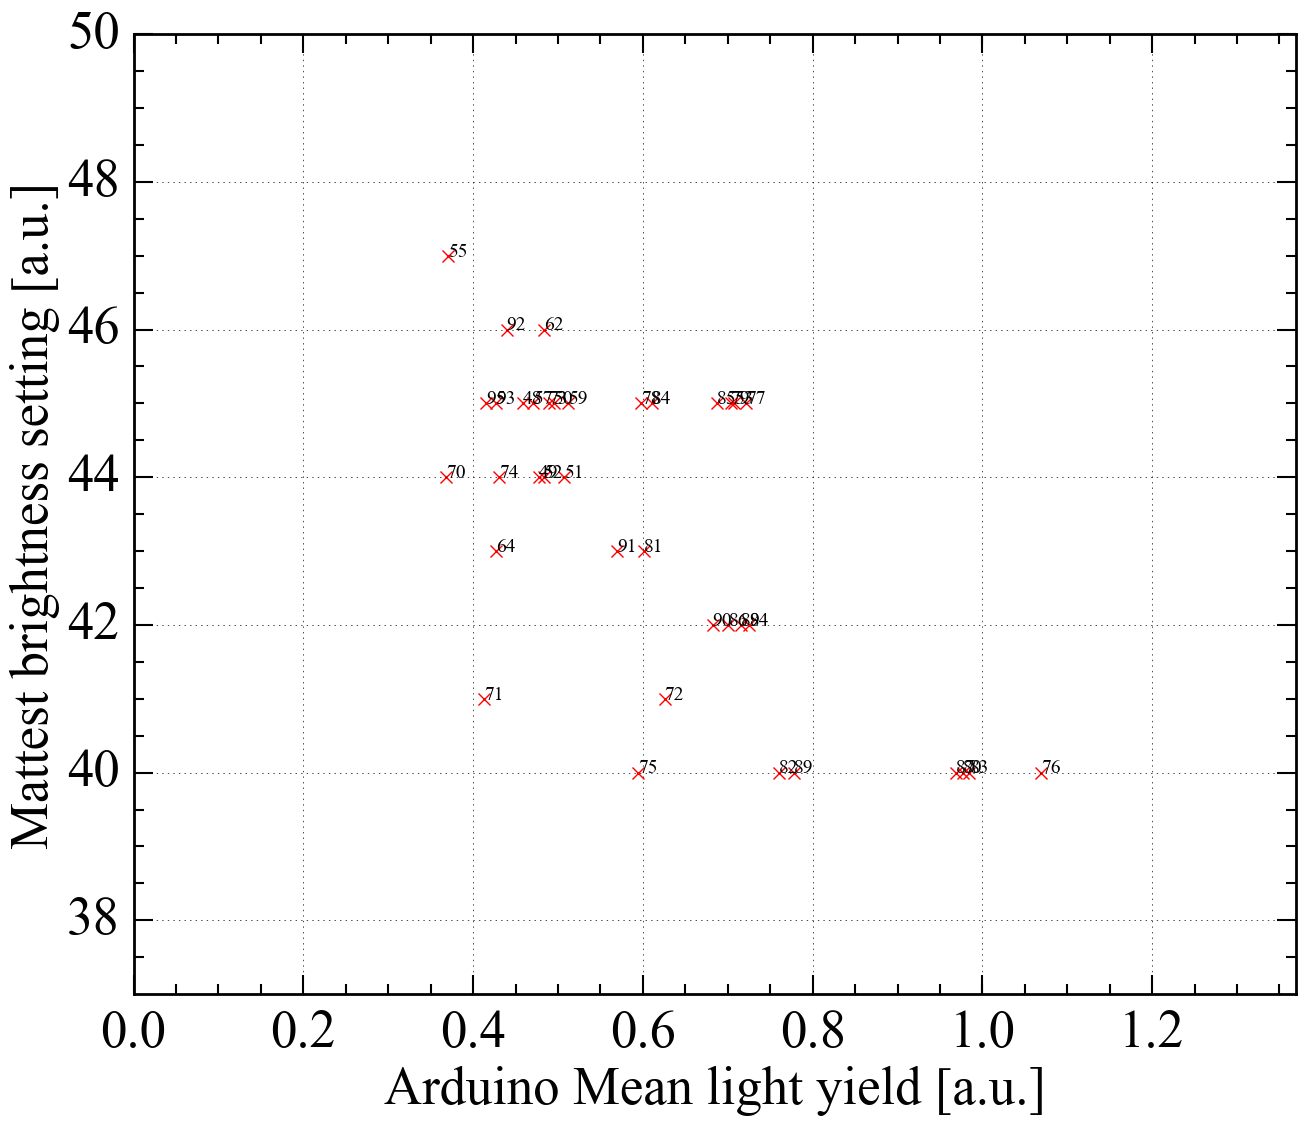

In [45]:
plt.plot( df["Arduino_Mean"], df["Mattest_Brightness"], "rx" )
for x,y, lightbar_nr in df[ ["Arduino_Mean", "Mattest_Brightness", "Lightbar"] ].values:
    plt.text(x,y, lightbar_nr)

plt.minorticks_on()
plt.grid()

plt.xlim(0,max(df["Arduino_Mean"]) + 0.3)
plt.ylim(min(df["Mattest_Brightness"]) - 3, max(df["Mattest_Brightness"]) + 3)
plt.xlabel("Arduino Mean light yield [a.u.]")
plt.ylabel("Mattest brightness setting [a.u.]")

### Arduino rel. std vs. mattest rel. std

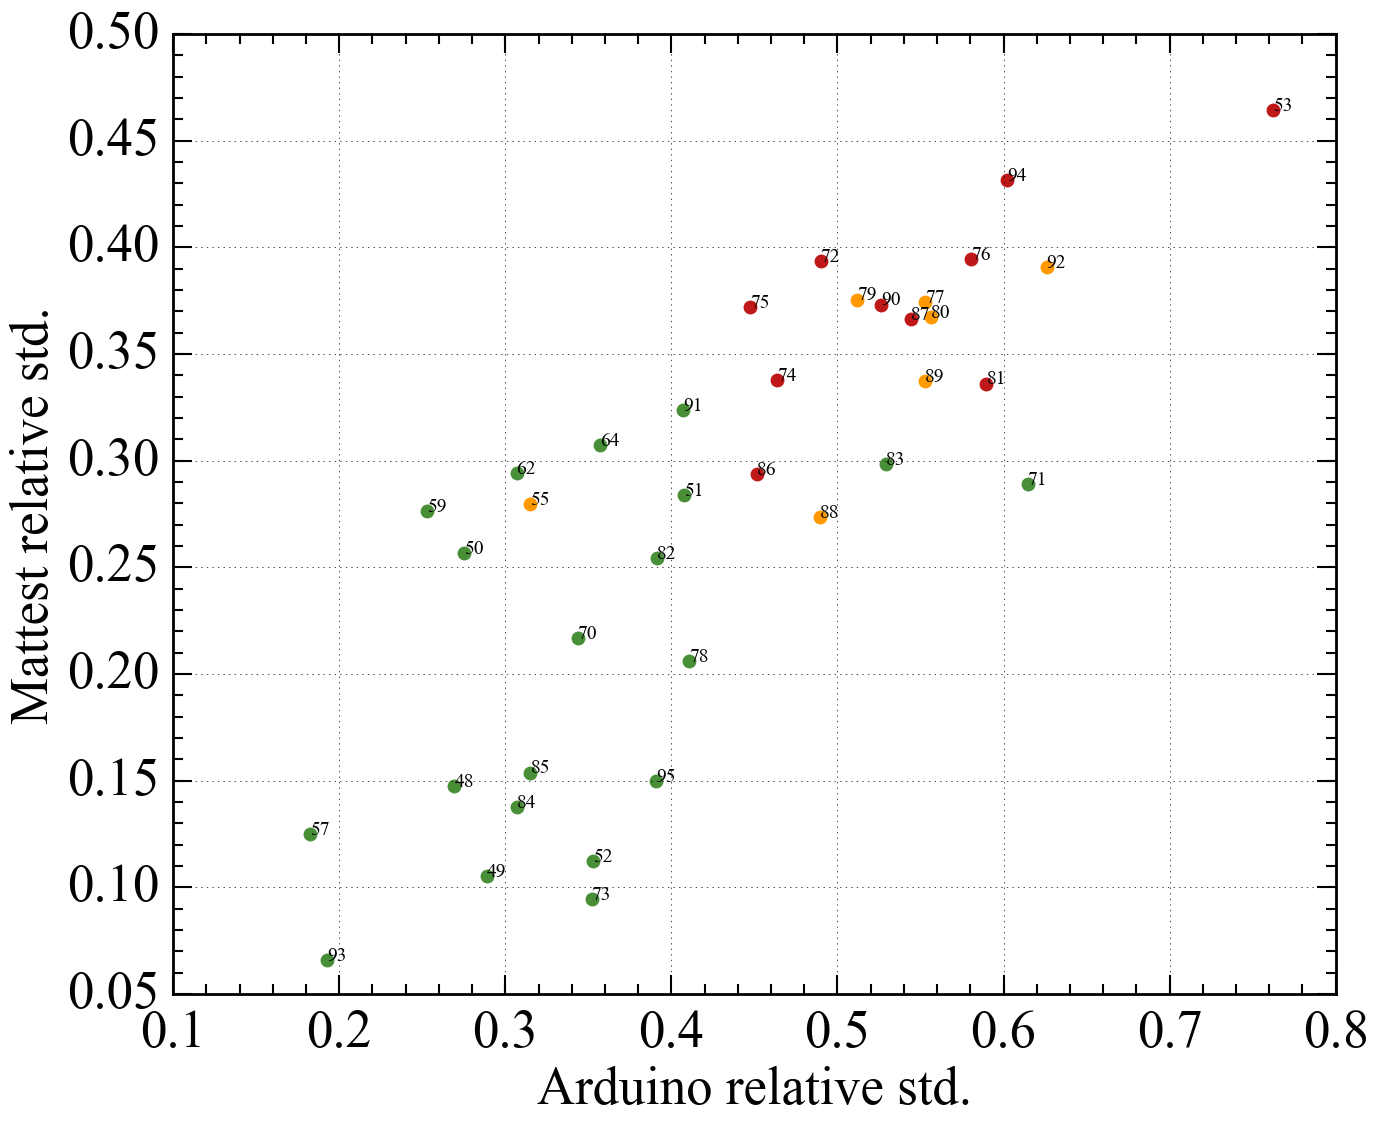

In [83]:
uniformity_colors = {"bad" : "gcred", "ok" : "gcorange", "good" : "gcgreen"}

#Plot in different colors
for key, value in uniformity_colors.iteritems():
    datapart = df.loc[ df["Uniformity"] == key ]
    line2d = plt.plot( datapart["Arduino_Rel_Std"], datapart["Mattest_Rel_Std"], 
                       color=value, marker="o", lw=0, mew=0, ms=10)[0]


#Show lightbar IDs    
for x,y, lightbar_nr in df[ ["Arduino_Rel_Std", "Mattest_Rel_Std", "Lightbar"] ].values:
    plt.text(x,y, int(lightbar_nr))

    
plt.minorticks_on() 
plt.grid()
#plt.xlim(0, max(df["Arduino_Rel_Std"]) + 0.1)
#plt.ylim(0, max(df["Mattest_Rel_Std"]) + 0.1)
plt.xlabel("Arduino relative std.")
plt.ylabel("Mattest relative std.")

### Arduino median uniformity vs. mattest uniformity

In [63]:
df

,Arduino_Data,In_Production,Mattest_Brightness,Mattest_Data,Lightbar,Uniformity,Mattest_Stepfactor,Arduino_Mean,Arduino_Rel_Std,Mattest_Mean,Mattest_Rel_Std,Mattest_Median_Uniformity,Arduino_Median_Uniformity
48,Ch Blue Red 0 0 0.35168...,1,45,Ch Pedestal Gain Mean_pixels Mean_p...,48,good,0.797931,0.458924,0.269314,224.362312,0.147476,0.743213,0.633333
49,Ch Blue Red 0 0 0.35096...,1,44,Ch Pedestal Gain Mean_pixels Mean_p...,49,good,0.801863,0.477175,0.288745,211.443833,0.105307,0.811353,0.580645
50,Ch Blue Red 0 0 0.36175...,1,45,Ch Pedestal Gain Mean_pixels Mean_p...,50,good,0.812892,0.494726,0.275066,226.697474,0.256691,0.852761,0.600000
51,Ch Blue Red 0 0 0.32178...,1,44,Ch Pedestal Gain Mean_pixels Mean_p...,51,good,0.795913,0.506718,0.407715,246.247584,0.283849,0.693331,0.484848
52,Ch Blue Red 0 0 0.35556...,1,44,Ch Pedestal Gain Mean_pixels Mean_p...,52,good,0.806437,0.482931,0.352727,246.743700,0.112418,0.814537,0.529412
53,Ch Blue Red 0 0 0.24498...,0,45,Ch Pedestal Gain Mean_pixels Mean_p...,53,bad,0.905602,0.707064,0.762133,401.250911,0.464221,0.325306,0.174603
55,Ch Blue Red 0 0 0.26996...,0,47,Ch Pedestal Gain Mean_pixels Mean_p...,55,ok,0.809886,0.370536,0.314909,281.859252,0.279807,0.505300,0.518519
57,Ch Blue Red 0 0 0.45893...,1,45,Ch Pedestal Gain Mean_pixels Mean_p...,57,good,0.794428,0.471135,0.182220,230.402659,0.125046,0.760669,0.769231
59,Ch Blue Red 0 0 0.38073...,1,45,Ch Pedestal Gain Mean_pixels Mean_p...,59,good,0.811679,0.512080,0.252738,278.630792,0.276300,0.662721,0.633333
62,Ch Blue Red 0 0 0.33944...,1,46,Ch Pedestal Gain Mean_pixels Mean_p...,62,good,0.816938,0.483784,0.306718,241.222104,0.294198,0.646923,0.548387


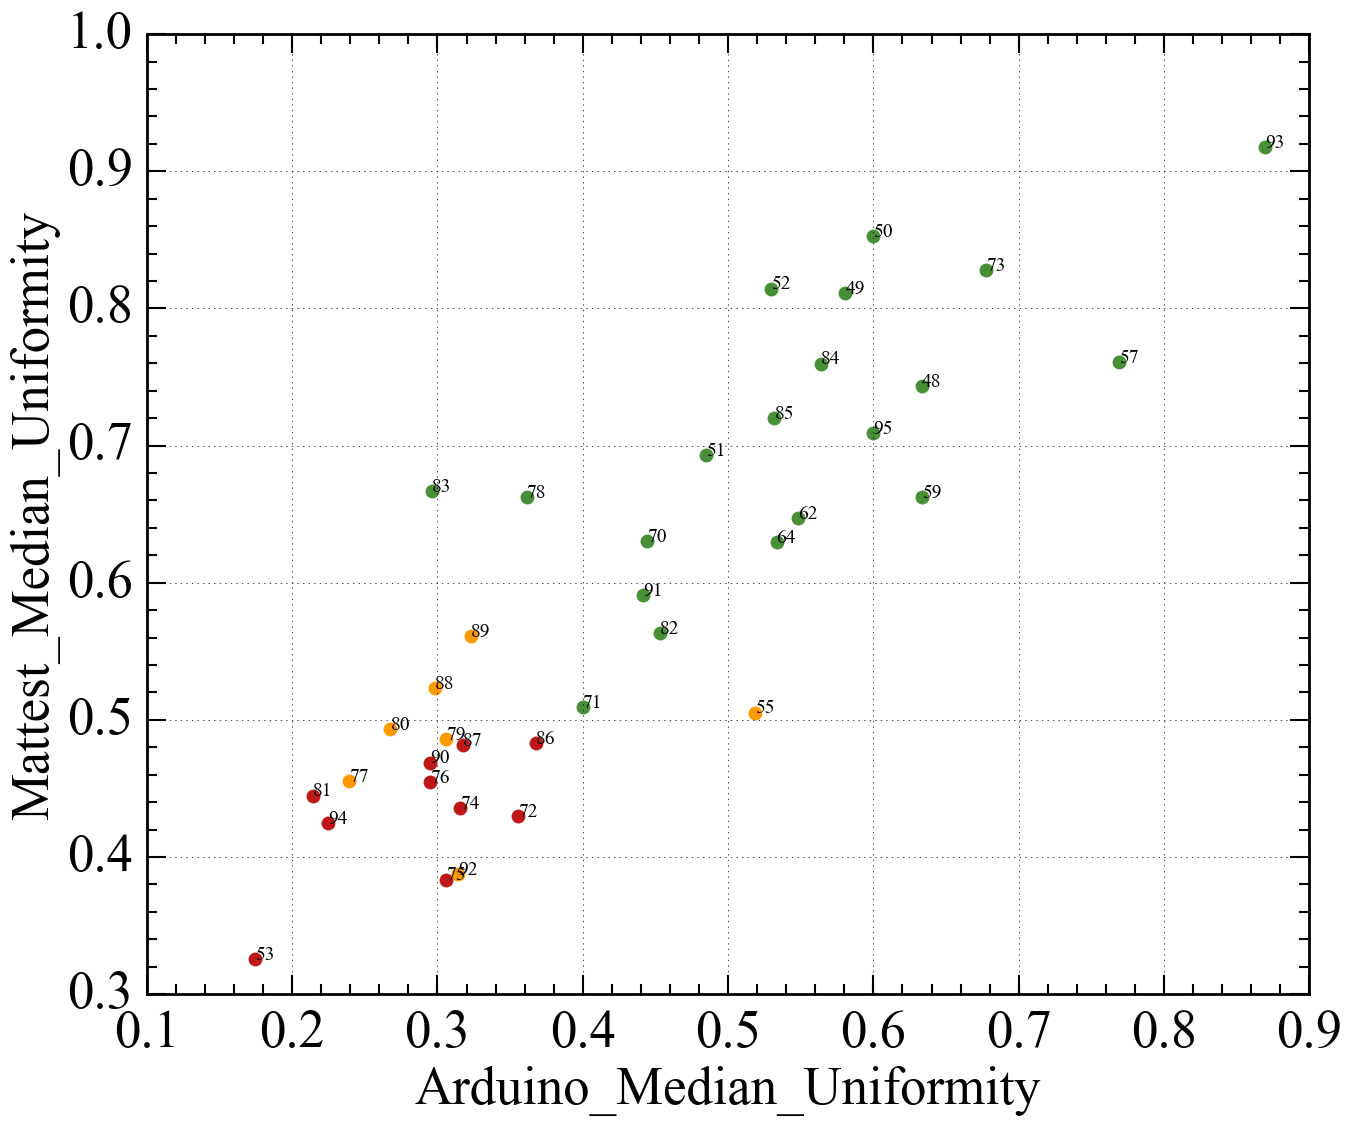

In [79]:
ycolumn = "Mattest_Median_Uniformity"
xcolumn = "Arduino_Median_Uniformity"

uniformity_colors = {"bad" : "gcred", "ok" : "gcorange", "good" : "gcgreen"}

#Plot in different colors
for key, value in uniformity_colors.iteritems():
    datapart = df.loc[ df["Uniformity"] == key ]
    line2d = plt.plot( datapart[xcolumn], datapart[ycolumn], 
                       color=value, marker="o", lw=0, mew=0, ms=10)[0]

#Plot numbers
for x,y, lightbar_nr in df[ [xcolumn, ycolumn, "Lightbar"] ].values:
    plt.text(x,y, int(lightbar_nr))
plt.minorticks_on()
plt.grid()

plt.xlabel(xcolumn)
plt.ylabel(ycolumn)